In [1]:
from model_utils.model_process import *
from floortrans.metrics import runningScore
from floortrans.plotting import discrete_cmap
discrete_cmap()

import warnings
warnings.filterwarnings('ignore')

## Data Loader

We employed a **MaskR-CNN model** for room detection. MaskR-CNN is a strong tool for both object detection and instance segmentation. At the end, we would try using it to detect each part of the floorplan, search for some specific room on the floorplan and recover the room segmentation map.

### Data Preprocessing and Augmentation

MaskR-CNN requires the **data loader** containing following inputs:

image: preprocessed to $256\times 256$, the training set includes random horizontal flips.

targets:
- boxes: the bounding boxes of each room instance
- labels: the labels of those rooms
- image_id: the integer identifier of the floorplan
- area: the instance area (based on the mask)
- iscrowd: instances with iscrowd=True will be ignored during evaluation.



The data loader code **CubicasaDataset** is in `model_utils/model_process.py`. We use OpenCV tools to automatically annotate the original floorplan images. 

The specific technique is to first extract each room instance mask out from the segmentation map processed in class `House` of the reference work https://github.com/CubiCasa/CubiCasa5k. They we use tools to find the mask's countour. The countours can further be used to calculate the instance area and find the bounding box vertices.

However, the method above cannot be used to get the accuracy information of walls since different walls are connected in the floorplan and therefore we cannot automatically break them into room pieces and find its target information. As a result, we only processed the other 10 room objects in our training, including "Outdoor", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", and "Undefined".

The ROOM_IDs are:
- Background: 0
- Outdoor:1
- Walls: 2
- Kitchen:3
- Living Room:4
- Bedroom: 5
- Bath: 6
- Entry: 7
- Railing: 8
- Storage: 9
- Garage: 10
- Undefined: 11

Notice that the background id is automatically assigned by the model. And we would add back walls in the postprocessing part.


### Kick out some problematic instances before trainig and evaluation

Our dataloader would automatically print out the instances with empty instances. Below shows some problematic examples we found.


In [2]:
def check_folder(folder_name, img_show = True):
    
        
    svg_path ='./data/cubicasa5k'+folder_name+'model.svg'
    img_path ='./data/cubicasa5k'+folder_name+'F1_scaled.png'
    org_img_path ='./data/cubicasa5k'+folder_name+'F1_original.png'
    height, width, _ = cv2.imread(img_path).shape
    height_org, width_org, _ = cv2.imread(org_img_path).shape

    house = House(svg_path, height, width)
    # Combining them to one numpy tensor
    gt = torch.tensor(house.get_segmentation_tensor().astype(np.float32))

    gt = gt.unsqueeze(0)
    gt = torch.nn.functional.interpolate(gt,size=(height_org, width_org),
                                                            mode='nearest')
    gt = gt.squeeze(0)[0]
    
    org_img = plt.imread(org_img_path)
   
    if img_show:
        
        fig = plt.figure()
        ax = plt.subplot(1, 2, 1)
        ax.imshow(org_img)
        ax.set_title('Original Floorplan', fontsize=10)

        ax = plt.subplot(1,2, 2)
        ax.set_title('Ground Truth segmap', fontsize=10)
        ax.imshow(gt, cmap='rooms', vmin=0, vmax=12-0.1)
        
   
        
        
        fig.suptitle(folder_name)
        plt.show()
        
        
    return gt

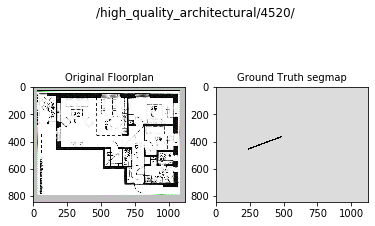

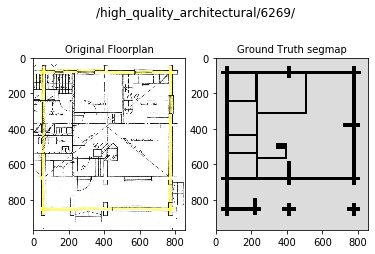

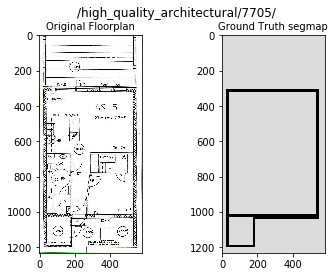

In [3]:
#problematic folders overview
folders = ['/high_quality_architectural/4520/', '/high_quality_architectural/6269/', '/high_quality_architectural/7705/']

for f in folders:
    _ = check_folder(f)
    
    

# Training method

The experiment is implemented on AWS Ubuntu 18.04 Deep Learning AMI with NVIDIA K80 GPU. The training script is in `maskrcnn.py`. Below are the details:

- model: torchvision.models.detection.maskrcnn_resnet50_fpn
- pretrained on COCO dataset.
- optimizer: SGD, lr = 0.005, momentum=0.9, weight_decay=0.0005
- lr scheduler: step_size=3,gamma=0.1
- epochs: 5, each takes about 100 mins.
- reference: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

$\mathcal{L} = \mathcal{L}_{classifier} +  \mathcal{L}_{classifier}+ \mathcal{L}_{box reg} + \mathcal{L}_{mask} $ The specific explanation of the losses refers to He et al. https://arxiv.org/pdf/1703.06870.pdf.


In [4]:
#here we use CPU for display
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#use test dataset for display
model, dataset_train, data_loader_train = prepare_model('train')
model, dataset_val, data_loader_val = prepare_model('val')
model, dataset_test, data_loader_test = prepare_model('test')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
    

The losses are decreasing slowly after the second epoch. The final loss was fluctuating between 0.6 and 0.7.

## Postprocessing
The **decoder** Decode_Maskrcnn is in `model_utils/model_process.py`. We use a non-maximum suppression on the number of bounding boxes on each floorplan. The suppression condition is that IoU > 1. For soft segmentation mask, we extract the masks with a value threshold >0.1 (the mask pixel values are within \[0,1\]).

### Overview

In [5]:
#load model
model.load_state_dict(torch.load('models/maskrcnn_3_resized.pt',map_location='cpu'))

#Input the dataset name, image_id, model and non-maximum suppression threshold.
dm = Decode_Maskrcnn(dataset_val, 0, model, nms = 1) 

### get ground truth

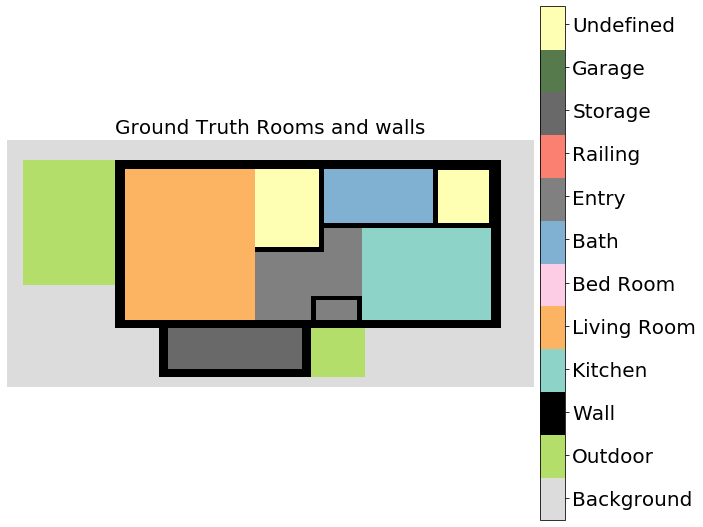

In [6]:
gt = dm.get_groundtruth()

### Get predicted segmentation map

The way to generate segmentation mask is to put the pieces of instances on all masks together and assign the ROOM_ID number on that pixel. Since we didn't have walls on the map, we can recover it by adding back countours with some thickness to the segmentation map.

It would be a better idea to add the edges with some thickness to the map. However, right now we haven't find any efficient way to implement it. This would in some degree affect the evaluation result.

Here we can also see some advantages of MASKR-CNN. Since the rooms are patches on the image, it is consistent with the function of object detection instead of semantic segmentation. The rooms on the segmentation map are patches without too much crosses on other rooms.

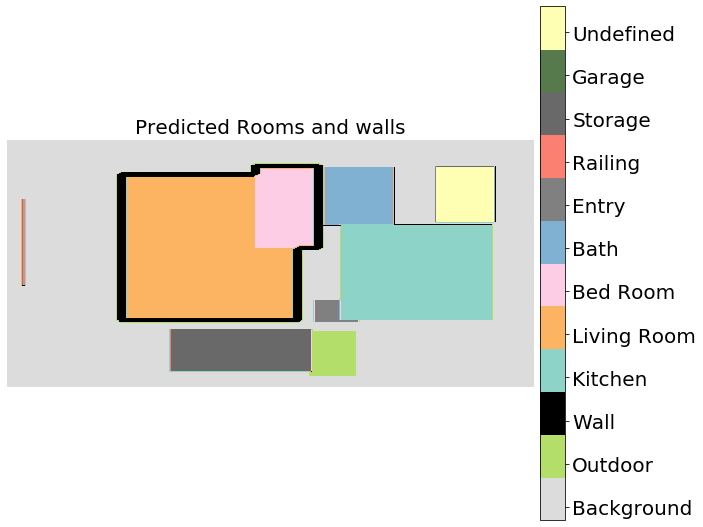

In [7]:
seg_map =  dm.get_segmap(0)

### Room detection

Since we preprocessed the images and bounding boxes with the image size $256 \times 256$, we rescaled the bounding boxes to match the original floorplan.

Our decoder allows to return the proposed regions of some specific rooms.

You can see the model proposed more than one area of bath while in fact there's only one batch on the floorplan. This is the propoerty of object detection model. Maximum suppression thus is very critical to prevent the model from overfitting.

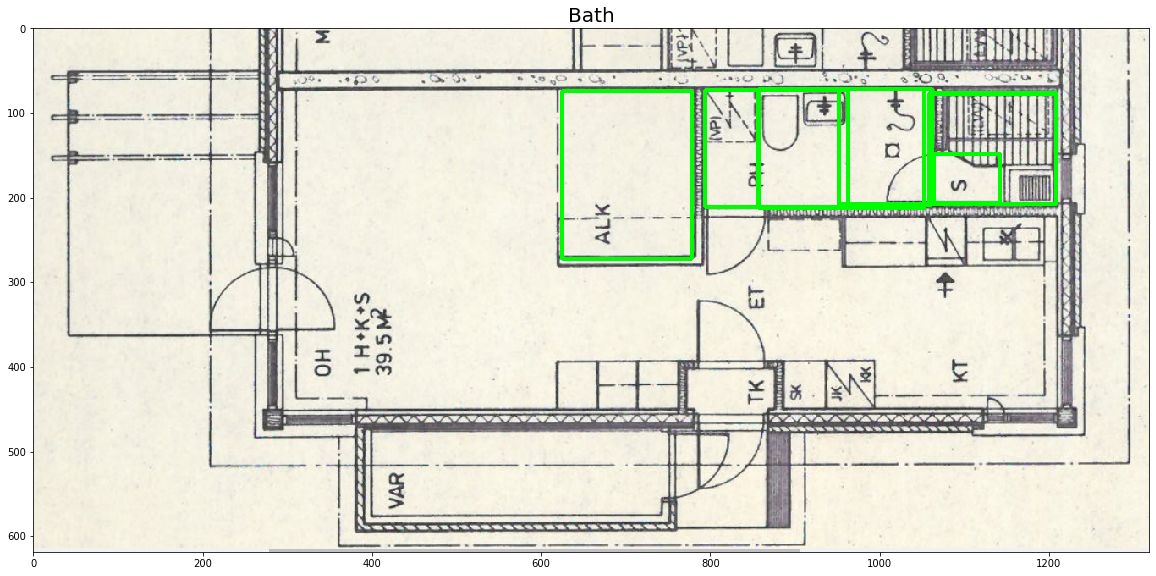

In [8]:
#Enter any room name to search for the room on the floorplan
bed_room =  dm.room_detect(ROOM_LABELS['Bath'])

In [9]:
# report None when no such object detected.
bed_room =  dm.room_detect(ROOM_LABELS['Garage'])

No such object


### Final display

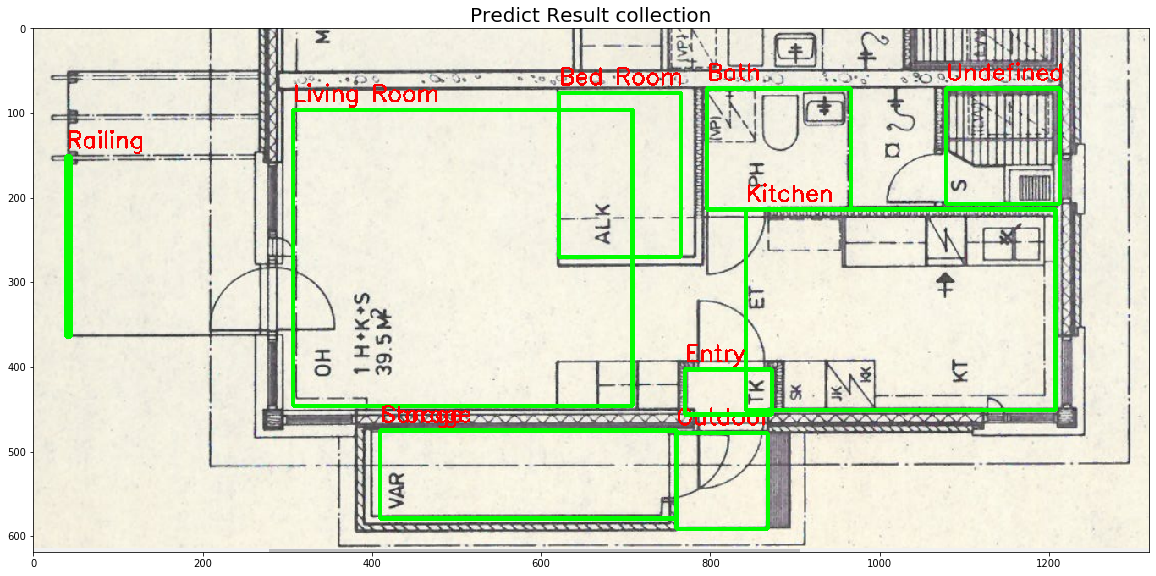

In [10]:
rc = dm.collect_result()

## Result

To evaluate our result, we matched the evaluation method used by Kalervo et al. The metrics and terms were explained in https://arxiv.org/abs/1904.01920v1, they are the different types of IoU metrics regarding our postprocessed segmentation maps.

The evaluated metrics:
- Overall Acc
- Mean Acc
- FreqW Acc
- Mean IoU






## Discussion